### Patient trajectory

#### Import libraries

In [1]:
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,col
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql import Window

#### Initiate spark

In [2]:
spark = SparkSession \
            .builder \
            .appName("Python Spark SQL basic example") \
            .config("spark.some.config.option", "some-value") \
            .getOrCreate()
spark

In [3]:
path_to_data = r'D:\skolaÅr5\MasterThesis\mimic-iv-1.0'

#### Read Patient and Admission table

In [4]:
df_pat = pd.read_csv(path_to_data  + r'\core\patients.csv')
df_adm = pd.read_csv(path_to_data + r'\core\admissions.csv')

##### Merge pat and adm

In [5]:
df_patadm = pd.merge(df_pat, df_adm, on=['subject_id'], how='inner')

In [6]:
df_patadm.head(2)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,10002723,F,0,2128,2017 - 2019,NaN,26724970,2128-06-10 15:29:00,2128-06-12 14:20:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,WHITE,NaN,NaN,0
1,10002723,F,0,2128,2017 - 2019,NaN,20429365,2128-06-13 14:15:00,2128-06-14 18:37:00,NaN,DIRECT EMER.,CLINIC REFERRAL,HOME,Medicaid,ENGLISH,NaN,WHITE,NaN,NaN,0


##### For visualization purposes, select 1 patient, which have at least 3 admissions*

In [140]:
admissions = df_patadm.groupby(['subject_id']).size().reset_index(name='count')
patient_id = 10020740 #14489052 #admissions[admissions['count'] == 6].sample(1)['subject_id'].tolist()[0]

In [141]:
patient_id

10020740

##### How many admissions did this patient have?

In [142]:
len(df_patadm[df_patadm['subject_id'] == patient_id])

5

#### Analyze patient in-depth

##### Gather all admissions

In [143]:
patientadm = df_adm[df_adm['subject_id'] == patient_id]

In [144]:
patientadm.head(2)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
339050,10020740,23199774,2150-09-15 14:09:00,2150-09-15 17:09:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2150-09-15 09:31:00,2150-09-15 17:09:00,0
343169,10020740,23143086,2151-01-15 15:25:00,2151-01-16 02:38:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2151-01-15 11:47:00,2151-01-16 02:38:00,0


##### Drop unc columns

In [145]:
patientadm.drop(columns=['hospital_expire_flag', 'deathtime', 'edregtime', 'edouttime', 'ethnicity', 'marital_status', 'insurance', 'discharge_location', 'admission_location', 'language'], inplace=True)

C:\Users\Johan\anaconda3\envs\spark_env\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
patientadm

,subject_id,hadm_id,admittime,dischtime,admission_type
339050,10020740,23199774,2150-09-15 14:09:00,2150-09-15 17:09:00,EU OBSERVATION
343169,10020740,23143086,2151-01-15 15:25:00,2151-01-16 02:38:00,EU OBSERVATION
348372,10020740,29820177,2150-07-09 22:09:00,2150-07-12 18:00:00,DIRECT OBSERVATION
364765,10020740,25826145,2150-06-03 20:12:00,2150-06-07 15:05:00,EW EMER.
380135,10020740,23831430,2150-03-11 15:34:00,2150-04-25 13:50:00,URGENT


##### Get diagnoses (ICD-9) for each admission

In [147]:
df_diagnoses = pd.read_csv(path_to_data + '\hosp\d_icd_diagnoses.csv')
df_diagnoses = df_diagnoses[df_diagnoses['icd_version'] == 9]

In [148]:
df_diagnoses

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A
...,...,...,...
102805,V9199,9,"Other specified multiple gestation, unable to ..."
109771,2880,9,Diseases of white blood cells
109772,7800,9,Alteration of consciousness
109773,V127,9,Personal history of digestive disease


In [149]:
df_patdiagnoses = pd.read_csv(path_to_data + '\hosp\diagnoses_icd.csv')
df_patdiagnoses = df_patdiagnoses[df_patdiagnoses['icd_version']==9]
df_patdiagnoses = pd.merge(df_patdiagnoses, df_diagnoses, on=['icd_code'], how='inner')
df_patdiagnoses = df_patdiagnoses[df_patdiagnoses['subject_id'] == patient_id]
df_patdiagnoses.drop(columns=['icd_version_y'], inplace=True)

In [150]:
df_patdiagnoses.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,long_title
29497,10020740,23199774,6,7840,9,Headache
173121,10020740,25826145,12,5680,9,Peritoneal adhesions (postoperative) (postinfe...
307043,10020740,25826145,9,29570,9,"Schizoaffective disorder, unspecified"
307081,10020740,29820177,6,29570,9,"Schizoaffective disorder, unspecified"
307127,10020740,23199774,2,29570,9,"Schizoaffective disorder, unspecified"


In [151]:
patientadms = pd.merge(df_patdiagnoses, patientadm, on=['subject_id', 'hadm_id'], how='inner')

In [152]:
patientadms.sort_values(by='admittime', inplace=True)

In [153]:
patientadms.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,long_title,admittime,dischtime,admission_type
57,10020740,23831430,24,78720,9,"Dysphagia, unspecified",2150-03-11 15:34:00,2150-04-25 13:50:00,URGENT
54,10020740,23831430,7,2760,9,Hyperosmolality and/or hypernatremia,2150-03-11 15:34:00,2150-04-25 13:50:00,URGENT
56,10020740,23831430,1,03842,9,Septicemia due to escherichia coli [E. coli],2150-03-11 15:34:00,2150-04-25 13:50:00,URGENT
53,10020740,23831430,6,2639,9,Unspecified protein-calorie malnutrition,2150-03-11 15:34:00,2150-04-25 13:50:00,URGENT
52,10020740,23831430,12,99591,9,Sepsis,2150-03-11 15:34:00,2150-04-25 13:50:00,URGENT


In [154]:
patientadms['admittime'] = pd.to_datetime(patientadms['admittime'])
patientadms['dischtime'] = pd.to_datetime(patientadms['dischtime'])

In [155]:
patientadms['time_stay'] = abs(patientadms['admittime'] - patientadms['dischtime']).apply(lambda x: x.days)

In [156]:
patientadms.head(2)

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,long_title,admittime,dischtime,admission_type,time_stay
57,10020740,23831430,24,78720,9,"Dysphagia, unspecified",2150-03-11 15:34:00,2150-04-25 13:50:00,URGENT,44
54,10020740,23831430,7,2760,9,Hyperosmolality and/or hypernatremia,2150-03-11 15:34:00,2150-04-25 13:50:00,URGENT,44


##### Get prescriptions for each admission

In [157]:
df_prescriptions = pd.read_csv(path_to_data + '\hosp\prescriptions.csv')

C:\Users\Johan\anaconda3\envs\spark_env\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [158]:
df_prescriptions.head(1)

,subject_id,hadm_id,pharmacy_id,starttime,stoptime,drug_type,drug,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,17868682,22726960,73313910,2160-01-07 08:00:00,2160-01-07 21:00:00,MAIN,BuPROPion (Sustained Release),046238,591083960.0,150mg SR Tablet,NaN,300,mg,2,TAB,1.0,PO


In [159]:
patient_id

10020740

In [160]:
df_patpresc = df_prescriptions[df_prescriptions['subject_id'] == patient_id]

##### Get labevents for each admission

In [161]:
#df_labevents = spark.read.load(path_to_data + '\hosp\labevents.csv', format="csv", sep=",", inferSchema="true", header="true")

In [162]:
#df_labevents.show(2)

##### Get procedures for each admission

In [163]:
df_procedures = pd.read_csv(path_to_data + '\hosp\procedures_icd.csv')
df_icd_procedures = pd.read_csv(path_to_data + '\hosp\d_icd_procedures.csv')

In [164]:
df_procedurespat = df_procedures[df_procedures['subject_id'] == patient_id]
df_icd_procedures[df_icd_procedures['icd_version'] == 9]

df_procedurespat = pd.merge(df_procedurespat, df_icd_procedures, on='icd_code')
df_procedurespat.drop(columns=['icd_version_x'], inplace=True)

In [165]:
df_procedurespat.head()

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version_y,long_title
0,10020740,23831430,12,2150-04-20,9427,9,Other electroshock therapy
1,10020740,23831430,6,2150-03-27,9427,9,Other electroshock therapy
2,10020740,23831430,7,2150-04-01,9427,9,Other electroshock therapy
3,10020740,23831430,8,2150-04-03,9427,9,Other electroshock therapy
4,10020740,23831430,9,2150-04-06,9427,9,Other electroshock therapy


##### Get ICU stays for each admission

In [166]:
df_icustays = pd.read_csv(path_to_data + '\icu\icustays.csv')
df_icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17867402,24528534,31793211,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-03-03 04:11:00,2154-03-04 18:16:56,1.587454
1,14435996,28960964,31983544,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-19 17:57:00,2150-06-22 18:33:54,3.025625
2,17609946,27385897,33183475,Trauma SICU (TSICU),Trauma SICU (TSICU),2138-02-05 18:54:00,2138-02-15 12:42:05,9.741725
3,18966770,23483021,34131444,Trauma SICU (TSICU),Trauma SICU (TSICU),2123-10-25 10:35:00,2123-10-25 18:59:47,0.350544
4,12776735,20817525,34547665,Neuro Stepdown,Neuro Stepdown,2200-07-12 00:33:00,2200-07-13 16:44:40,1.674769


In [167]:
df_paticustatys = df_icustays[df_icustays['subject_id'] == patient_id]

##### Get procedures during icu stays for each admission

In [168]:
df_procicu = pd.read_csv(path_to_data + '\icu\procedureevents.csv')
df_procicu.head()

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,value,valueuom,location,...,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_date,originalamount,originalrate
0,15693895,21203492,30500789,2147-06-05 11:25:00,2147-06-05 11:26:00,2147-06-06 11:25:00,225399,1.0,None,NaN,...,80.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
1,15693895,21203492,30500789,2147-06-05 22:00:00,2147-06-05 22:01:00,2147-06-06 11:25:00,224385,1.0,None,NaN,...,80.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
2,12481680,26876606,30863119,2141-01-23 12:00:00,2141-01-23 18:33:00,2141-01-23 18:33:51.14,224275,393.0,min,NaN,...,123.0,NaN,NaN,1,0,0,FinishedRunning,NaN,393.0,1
3,12481680,26876606,30863119,2141-01-23 12:00:00,2141-01-23 18:33:00,2141-01-23 18:33:51.14,224275,393.0,min,NaN,...,123.0,NaN,NaN,1,0,0,FinishedRunning,NaN,393.0,1
4,15614172,27424463,33484414,2153-07-29 18:13:00,2153-07-31 01:25:00,2153-07-31 01:26:00,224277,1872.0,min,RL Post Forearm,...,71.6,NaN,NaN,1,1,0,FinishedRunning,NaN,1872.0,1


In [169]:
df_procicupat = df_procicu[df_procicu['subject_id'] == patient_id]
df_procicupat.head()

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,value,valueuom,location,...,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_date,originalamount,originalrate
503778,10020740,23831430,35026312,2150-03-11 15:45:00,2150-03-12 18:15:00,2150-03-12 18:35:00,225792,1590.0,min,NaN,...,1.0,NaN,NaN,1,0,0,FinishedRunning,NaN,1590.0,1
503779,10020740,23831430,35026312,2150-03-11 16:00:00,2150-03-12 22:32:00,2150-03-12 22:33:00,224275,1832.0,min,Left Accessory Basilic,...,1.0,NaN,NaN,1,0,0,FinishedRunning,NaN,1832.0,1
503780,10020740,23831430,35026312,2150-03-11 16:00:00,2150-03-19 02:17:00,2150-03-19 02:17:50.33,224264,10697.0,min,NaN,...,1.0,NaN,NaN,1,0,0,FinishedRunning,NaN,10697.0,1
503781,10020740,23831430,35026312,2150-03-11 16:15:00,2150-03-11 16:16:00,2150-03-11 16:34:00,225459,1.0,None,NaN,...,1.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
503782,10020740,23831430,35026312,2150-03-11 16:53:00,2150-03-11 16:54:00,2150-03-11 16:53:00,225966,1.0,None,NaN,...,1.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0


##### Get chartevents from icu stays for each admission

In [38]:
#df_chartevents = spark.read.load(path_to_data + '\icu\chartevents.csv', format="csv", sep=",", inferSchema="true", header="true")

In [132]:
#df_charteventspat = df_chartevents.filter(col('subject_id') == patient_id)

### Patient Journey

In [170]:
from datetime import date

In [171]:
admissiontypes = patientadms['admission_type'].unique()
patientadms['adm_date'] = patientadms['admittime'].apply(lambda x: date(x.year, x.month, x.day))
patientadms['disch_date'] = patientadms['dischtime'].apply(lambda x: date(x.year, x.month, x.day))

In [172]:
uniqueadm = patientadms['hadm_id'].unique()

In [173]:
admissions = patientadms.drop_duplicates('hadm_id')
admdates = admissions['adm_date'].tolist()
discdates = admissions['disch_date'].tolist()
admissiontype = admissions['admission_type'].tolist()

In [174]:
admissiontype

['URGENT',
 'EW EMER.',
 'DIRECT OBSERVATION',
 'EU OBSERVATION',
 'EU OBSERVATION']

In [175]:
adm_disc = []
for idx, (admtime, dischtime) in enumerate(zip(admdates, discdates)):
    adm_disc.append(admtime)
    adm_disc.append(dischtime)    

Text(0.5, 1.0, 'Admissions for patient 10020740')

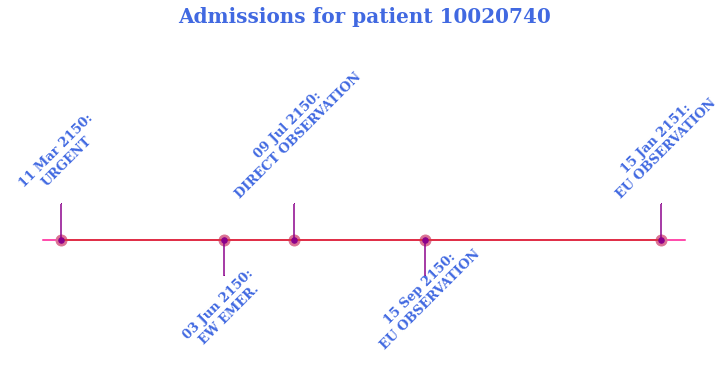

In [210]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
from datetime import date
import numpy as np
# reference: https://mentalitch.com/key-events-in-rock-and-roll-history/
dates = admdates #[date(1954, 7, 19), date(1959, 2, 3), date(1964, 2, 9), date(1965, 7, 25), date(1967, 6, 1), date(1969, 8, 15)]
#dates = [date(x.year, x.date, x.days) for x in patientadms['admittime'].unique()[:3]]
#print(dates)


min_date = date(admdates[0].year, admdates[0].month - 1, admdates[0].day) #date(np.min(dates).year - 2, np.min(dates).month, np.min(dates).day)
max_date = date(admdates[-1].year, admdates[-1].month + 1, admdates[-1].day) #date(np.max(dates).year + 2, np.max(dates).month, np.max(dates).day)
 
labels = admissiontype# ['EW EMER', 'EW EMER', 'EW EMER', 'EW EMER']
# labels with associated dates
labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.set_ylim(-1, 1.75)
ax.set_xlim(min_date, max_date)
ax.axhline(0, xmin=0.05, xmax=0.95, c='deeppink', zorder=1)

# For admtime
ax.scatter(dates, np.zeros(len(dates)), s=120, c='palevioletred', zorder=2)
ax.scatter(dates, np.zeros(len(dates)), s=30, c='darkmagenta', zorder=3)


label_offsets = np.zeros(len(dates))
label_offsets[::2] = 0.35
label_offsets[1::2] = -0.9

for i, (l, d) in enumerate(zip(labels, dates)):
    ax.text(d, label_offsets[i], l, ha='center', rotation=45,fontfamily='serif', fontweight='bold', color='royalblue',fontsize=13)


stems = np.zeros(len(dates))
stems[::2] = 0.3
stems[1::2] = -0.3   
markerline, stemline, baseline = ax.stem(dates, stems, use_line_collection=True)
plt.setp(markerline, marker=',', color='darkmagenta')
plt.setp(stemline, color='darkmagenta')
#
# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
 
ax.set_title('Admissions for patient {}'.format(patient_id), fontweight="bold", fontfamily='serif', fontsize=20, color='royalblue')

In [196]:
#fig.savefig('admissions.png')

AttributeError: 'Figure' object has no attribute 'savefig'

#### Received diagnoses


In [233]:
patientadms[['hadm_id' ,'icd_code', 'long_title']].head()

,hadm_id,icd_code,long_title
57,23831430,78720,"Dysphagia, unspecified"
54,23831430,2760,Hyperosmolality and/or hypernatremia
56,23831430,03842,Septicemia due to escherichia coli [E. coli]
53,23831430,2639,Unspecified protein-calorie malnutrition
52,23831430,99591,Sepsis


In [236]:
admissions = patientadms['hadm_id'].unique().tolist()

In [237]:
admissions 

[23831430, 25826145, 29820177, 23199774, 23143086]

In [ ]:
patientadms1 = patientadms[['hadm_id']]

In [238]:
#diagnoses_peradmission = patientadms.groupby(['hadm_id']).size().reset_index(name='count')

In [239]:
#import seaborn as sns

In [240]:
#fig, ax = plt.subplots(figsize=(6, 6))
#sns.countplot(x='hadm_id', data=patientadms, order = patientadms['hadm_id'].value_counts().index)

In [298]:
adm1data = patientadms[patientadms['hadm_id'] == 23143086]

In [299]:
adm1data

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,long_title,admittime,dischtime,admission_type,time_stay,adm_date,disch_date
64,10020740,23143086,2,25000,9,Diabetes mellitus without mention of complicat...,2151-01-15 15:25:00,2151-01-16 02:38:00,EU OBSERVATION,0,2151-01-15,2151-01-16
65,10020740,23143086,3,V5867,9,Long-term (current) use of insulin,2151-01-15 15:25:00,2151-01-16 02:38:00,EU OBSERVATION,0,2151-01-15,2151-01-16
66,10020740,23143086,1,29574,9,"Schizoaffective disorder, chronic with acute e...",2151-01-15 15:25:00,2151-01-16 02:38:00,EU OBSERVATION,0,2151-01-15,2151-01-16


In [300]:
cols = ['icd_code', 'long_title', 'seq_num']

In [301]:
adm1datashort = adm1data.iloc[:10]

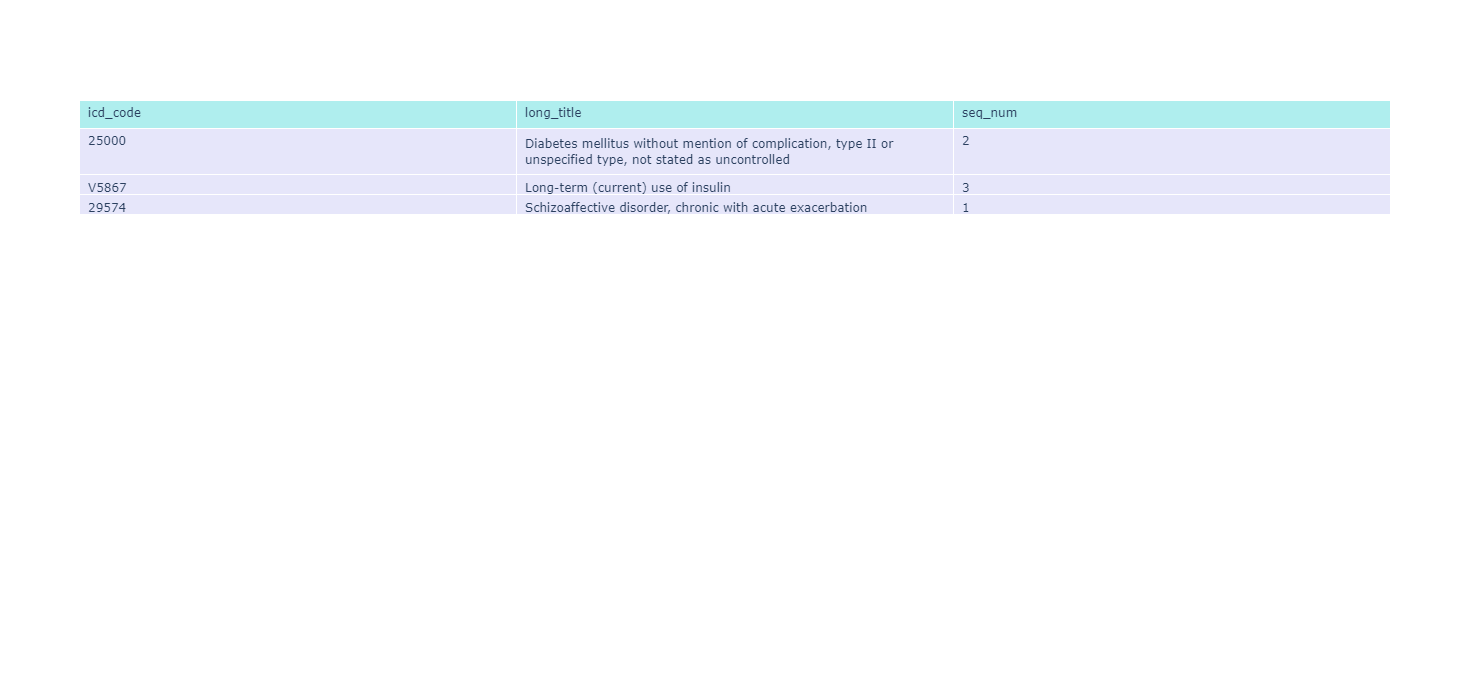

In [302]:
fig = go.Figure(data=[go.Table(
    header=dict(values=cols,
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[adm1datashort.icd_code, adm1datashort.long_title, adm1datashort.seq_num],
               fill_color='lavender',
               align='left'))
])
fig.update_layout(width=700, height=700)
fig.show()

#### Received prescriptions

In [303]:
df_patpresc.head(5)

,subject_id,hadm_id,pharmacy_id,starttime,stoptime,drug_type,drug,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
13868803,10020740,23831430,18201238,2150-03-20 08:00:00,2150-03-21 11:00:00,BASE,Iso-Osmotic Dextrose,NaN,0.0,200ml Bag,NaN,200,mL,200,mL,2.0,IV
13869427,10020740,23831430,81671301,2150-03-24 12:00:00,2150-03-26 04:00:00,BASE,Iso-Osmotic Dextrose,NaN,0.0,100ml Bag,NaN,100,mL,100,mL,3.0,IV
13869639,10020740,23831430,18201238,2150-03-20 08:00:00,2150-03-21 11:00:00,MAIN,Vancomycin,043952,338355248.0,1g Frozen Bag,NaN,1000,mg,1,BAG,2.0,IV
13869901,10020740,23831430,4571809,2150-03-11 18:00:00,2150-03-23 21:00:00,MAIN,Sodium Chloride 0.9% Flush,NaN,0.0,10 mL Syringe,NaN,10,mL,1,SYR,1.0,IV
13869902,10020740,23831430,39956701,2150-03-11 18:00:00,2150-03-11 19:00:00,MAIN,Fentanyl Citrate,041384,409909332.0,100mcg/2mL Amp,NaN,25-100,mcg,0.5-2,mL,NaN,IV


<AxesSubplot:xlabel='hadm_id', ylabel='count'>

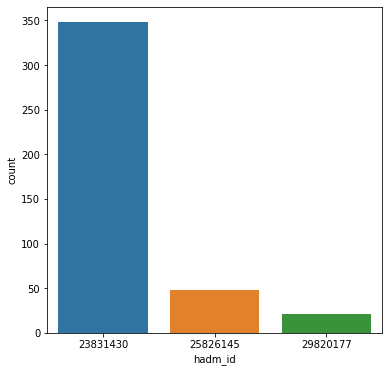

In [219]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.countplot(x='hadm_id', data=df_patpresc, order = df_patpresc['hadm_id'].value_counts().index)

In [370]:
#adm_id = patientadms['hadm_id'].sample(n=1).iloc[0]
admissions

[23831430, 25826145, 29820177, 23199774, 23143086]

In [420]:
adm_id = 23143086

In [421]:
#df_patpresc[df_patpresc['hadm_id'] == adm_id].head(3)

In [422]:
df_patpresc_adm = df_patpresc[df_patpresc['hadm_id'] == adm_id]

In [423]:
import plotly.graph_objs as go

In [424]:
df_patpresc_adm.head(3)

,subject_id,hadm_id,pharmacy_id,starttime,stoptime,drug_type,drug,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route


In [407]:
import random

In [413]:
#uniquedrugs = random.sample(df_patpresc_adm['drug'].unique().tolist(), 5)

In [414]:
uniquedrugs

['Glucagon',
 'Glucose Gel',
 'MetFORMIN (Glucophage)',
 'Vial',
 'Lorazepam',
 'Senna',
 'DiphenhydrAMINE',
 'Acetaminophen IV',
 'Pantoprazole',
 'Acetaminophen']

In [415]:
uniquedrugs

['Glucagon',
 'Glucose Gel',
 'MetFORMIN (Glucophage)',
 'Vial',
 'Lorazepam',
 'Senna',
 'DiphenhydrAMINE',
 'Acetaminophen IV',
 'Pantoprazole',
 'Acetaminophen']

In [417]:
uniquedrugs = random.sample(df_patpresc_adm['drug'].unique().tolist(), 10)
df_patpresc_admunq = df_patpresc_adm[df_patpresc_adm['drug'].isin(uniquedrugs)]

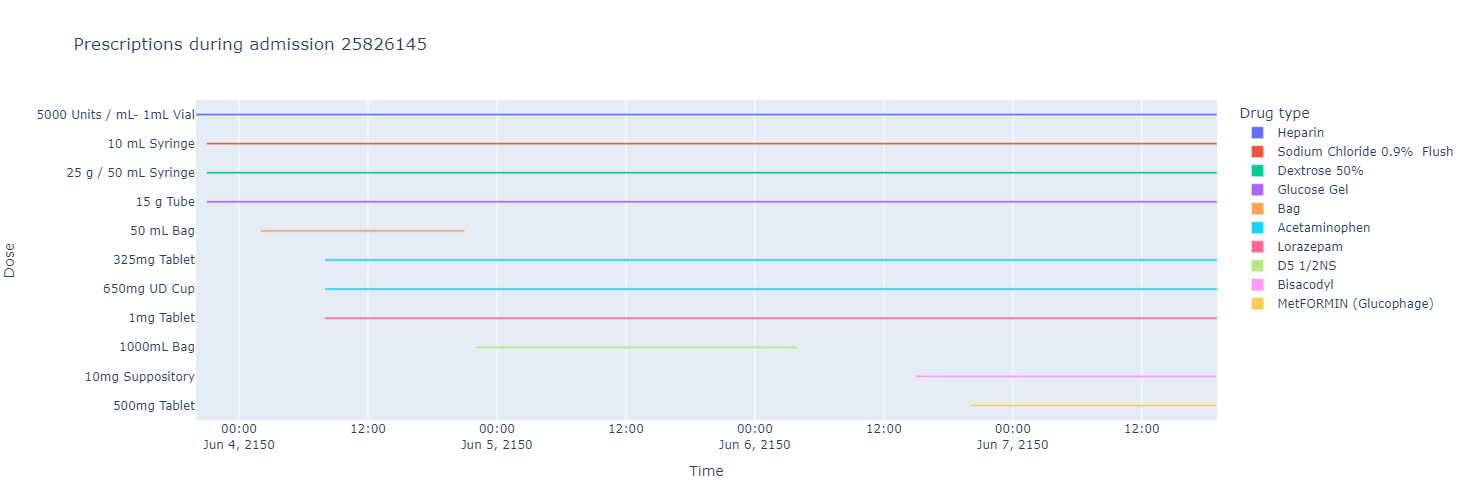

In [419]:
fig = px.timeline(df_patpresc_admunq, x_start="starttime", x_end="stoptime", y='prod_strength', color='drug', width=1000, height=500, title='Prescriptions during admission {}'.format(adm_id))
fig.update_traces(width=0.08) 
fig.update_xaxes(range=[df_patpresc_admunq['starttime'].min(), df_patpresc_admunq['stoptime'].max()])
fig.update_yaxes(autorange="reversed")

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Dose",
    legend_title="Drug type",
)
fig.show()

#### Procedures for a given admission

In [330]:
admissions 

[23831430, 25826145, 29820177, 23199774, 23143086]

In [362]:
adm_id = 25826145

In [363]:
df_procedurespatadm = df_procedurespat[df_procedurespat['hadm_id'] == adm_id]

In [364]:
df_procedurespatadm

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version_y,long_title
16,10020740,25826145,1,2150-06-03,5124,9,Laparoscopic partial cholecystectomy
17,10020740,25826145,2,2150-06-03,5451,9,Laparoscopic lysis of peritoneal adhesions
18,10020740,25826145,3,2150-06-03,5343,9,Other laparoscopic umbilical herniorrhaphy


In [351]:
#patientadms

In [365]:
starttime = patientadms[patientadms['hadm_id'] == adm_id]['adm_date'].iloc[0]
endtime = patientadms[patientadms['hadm_id'] == adm_id]['disch_date'].iloc[0]

In [366]:
#patientadms.head()

In [367]:
print(starttime, endtime)

2150-06-03 2150-06-07


In [368]:
df_procedurespatadm

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version_y,long_title
16,10020740,25826145,1,2150-06-03,5124,9,Laparoscopic partial cholecystectomy
17,10020740,25826145,2,2150-06-03,5451,9,Laparoscopic lysis of peritoneal adhesions
18,10020740,25826145,3,2150-06-03,5343,9,Other laparoscopic umbilical herniorrhaphy


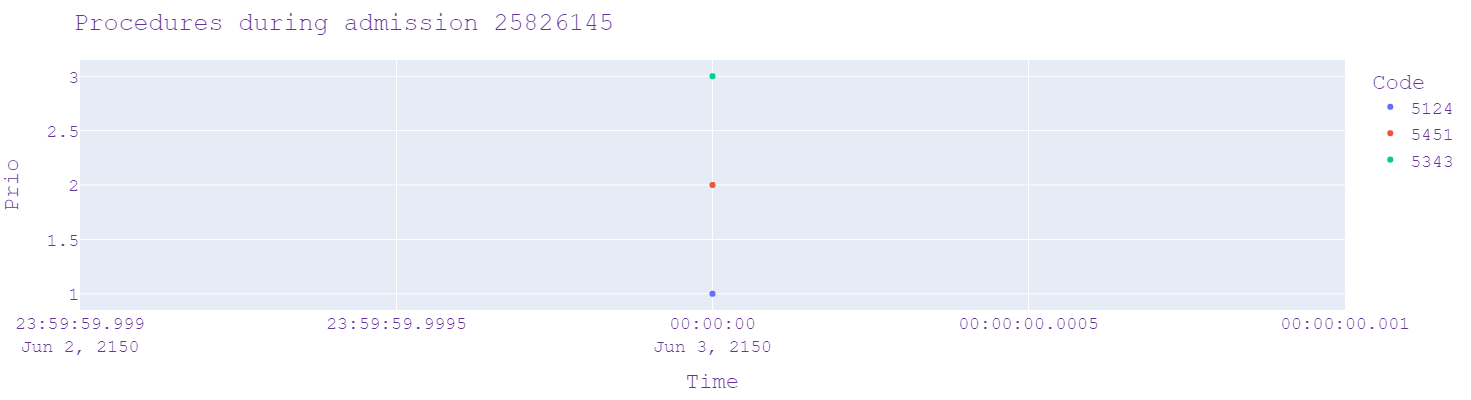

In [369]:
fig = px.scatter(df_procedurespatadm, x="chartdate", y="seq_num", color='icd_code', width=800, height=400)

fig.update_layout(
    title="Procedures during admission {}".format(adm_id),
    xaxis_title="Time",
    yaxis_title="Prio",
    legend_title="Code",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

#### Labevents for a given admission

In [68]:
#df_labspatient = df_labevents.filter(col('subject_id') == patient_id)

In [69]:
#df_labspatient.show(2)

#### Admissions to the ICU for a given admission

In [425]:
admissions

[23831430, 25826145, 29820177, 23199774, 23143086]

In [444]:
adm_id = 23143086

In [445]:
df_paticustatysadm = df_paticustatys[df_paticustatys['hadm_id'] == adm_id]

In [446]:
df_paticustatysadm['intime'] = pd.to_datetime(df_paticustatysadm['intime'])
df_paticustatysadm['outtime'] = pd.to_datetime(df_paticustatysadm['outtime'])

In [447]:
df_paticustatysadm.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los


In [441]:
df_paticustatysadm['outtime']

49784   2150-06-04 21:05:58
Name: outtime, dtype: datetime64[ns]

In [442]:
import plotly.express as px

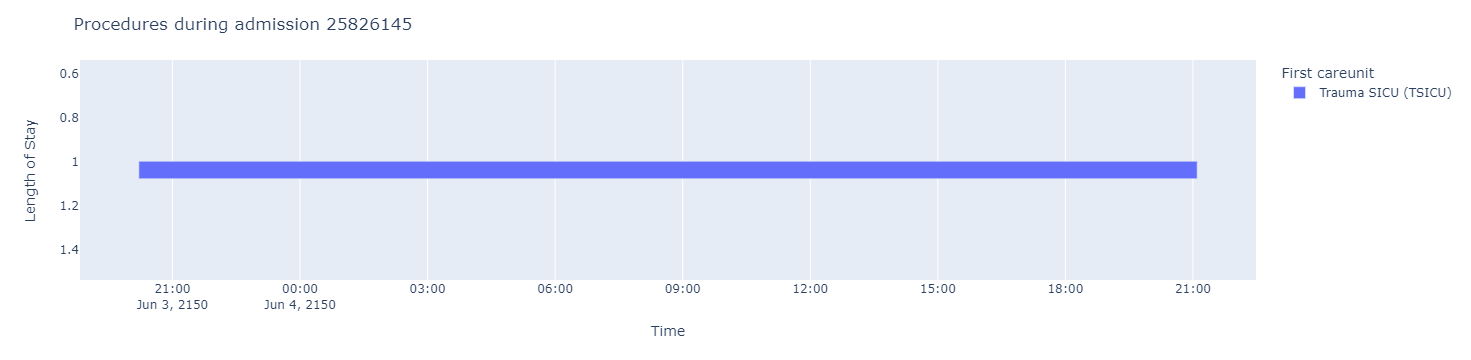

In [443]:
fig = px.timeline(df_paticustatysadm, x_start="intime", x_end="outtime",y='los', color='first_careunit')
fig.update_yaxes(autorange="reversed")
fig.update_layout(
    title="Procedures during admission {}".format(adm_id),
    xaxis_title="Time",
    yaxis_title="Length of Stay",
    legend_title="First careunit",
    autosize=False,
    width=1000,
    height=300
)

fig.update_traces(width=0.08) 
fig.show()

#### Procedures within ICU stays for a given admission

In [76]:
df_items = pd.read_csv(path_to_data + '\icu\d_items.csv')

In [77]:
df_items

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
1,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
2,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
3,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,NaN,Text,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3856,229355,Absolute Neutrophil Count,Absolute Neutrophil Count,chartevents,Labs,None,Numeric,NaN,NaN
3857,229453,Exam-GI/GU,Exam-GI/GU,chartevents,MD Progress Note,NaN,Text,NaN,NaN
3858,229604,Therapeutic Bed,Therapeutic Bed,chartevents,Treatments,NaN,Text,NaN,NaN
3859,229709,Angiotensin II (Giapreza),Angiotensin II (Giapreza),inputevents,Medications,mg,Solution,NaN,NaN


In [78]:
df_items[df_items['itemid'] == 224274]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
444,224274,22 Gauge,22 Gauge,procedureevents,Access Lines - Peripheral,None,Processes,NaN,NaN


In [79]:
df_procicupatadm = df_procicupat[df_procicupat['hadm_id'] == adm_id] 

In [80]:
df_procicupatadm.head()

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,value,valueuom,location,...,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_date,originalamount,originalrate


In [81]:
df_procicupatadm['itemid'] = df_procicupatadm['itemid'].apply(lambda x: str(x))
df_procicupatadm['stay_id'] = df_procicupatadm['stay_id'].apply(lambda x: str(x))

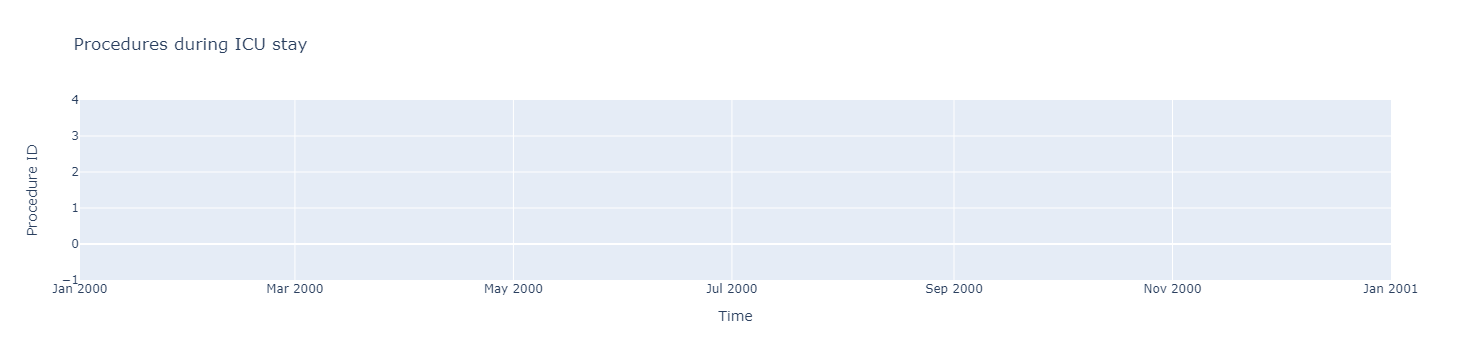

In [82]:
fig = px.timeline(df_procicupatadm, x_start="starttime", x_end="endtime", y='itemid', color='stay_id', title='Procedures during ICU stay')
fig.update_yaxes(autorange="reversed")
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Procedure ID",
    legend_title="ICU stay ID",
    autosize=False,
    width=1000,
    height=300
)
fig.show()

#### Chartevents within ICU for a given admission

In [83]:
df_charteventspatpd = df_charteventspat.toPandas()

In [84]:
df_charteventspatpdadm = df_charteventspatpd[df_charteventspatpd['hadm_id'] == adm_id]

In [85]:
df_charteventspatpdadmitms = pd.merge(df_charteventspatpdadm, df_items, on='itemid', how='inner')

##### Create day, month, hour columns

In [86]:
df_charteventspatpdadmitms['charttime'] = pd.to_datetime(df_charteventspatpdadmitms['charttime'])

In [87]:
df_charteventspatpdadmitms['day'] = df_charteventspatpdadmitms['charttime'].apply(lambda x: x.day)
df_charteventspatpdadmitms['month'] = df_charteventspatpdadmitms['charttime'].apply(lambda x: x.month)
df_charteventspatpdadmitms['hour'] = df_charteventspatpdadmitms['charttime'].apply(lambda x: x.hour)

In [88]:
df_charteventspatpdadmitmsheart = df_charteventspatpdadmitms[df_charteventspatpdadmitms['label'] == 'Heart Rate']

In [89]:
df_charteventspatpdadmitmsheart['day'] = df_charteventspatpdadmitmsheart['charttime'].apply(lambda x: x.day)

In [90]:
df_charteventspatpdadmitmsheart.head()

,subject_id,hadm_id,stay_id,charttime,storetime,value,valuenum,valueuom,warning,itemid,...,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue,day,month,hour


In [91]:
df_charteventspatpdadmitmsheart = df_charteventspatpdadmitmsheart[df_charteventspatpdadmitmsheart['day'] == 26]

In [92]:
df_charteventspatpdadmitms

,subject_id,hadm_id,stay_id,charttime,storetime,value,valuenum,valueuom,warning,itemid,...,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue,day,month,hour


##### Sample a random date

In [93]:
df_charteventrandom = df_charteventspatpdadmitms.sample(n=1)[['month', 'hour', 'day']]

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
month, hour, day = df_charteventrandom.iloc[0]

In [ ]:
print(month, hour, day)

In [ ]:
charts = df_charteventspatpdadmitms[(df_charteventspatpdadmitms['day'] == day) & (df_charteventspatpdadmitms['month'] == month)]

In [ ]:
charts[charts['param_type'] == 'Numeric']['label'].unique()

In [ ]:
charts = charts[charts['label'].isin(['Heart Rate', 'Respiratory Rate'])]

In [ ]:
charts.head()

In [ ]:
fig = px.scatter(charts, x='charttime', y="value", color='label')
#fig.update_yaxes(autorange="reversed")
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Value",
    legend_title="Type",
    autosize=False,
    width=1000,
    height=500
)
fig.show()

### Test, Remove later

In [ ]:
admissions

In [94]:
patientadmwithicu = pd.merge(df_adm, df_icustays, on=['subject_id', 'hadm_id'], how='inner')

In [95]:
patientadmwithicu

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,...,ethnicity,edregtime,edouttime,hospital_expire_flag,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17275231,23654078,2147-03-19 18:47:00,2147-03-23 12:55:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,...,WHITE,2147-03-19 16:18:00,2147-03-19 20:40:00,0,36243138,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2147-03-20 00:40:44,2147-03-21 21:54:24,1.884491
1,10222255,28200985,2120-11-20 20:25:00,2120-11-22 13:00:00,NaN,EU OBSERVATION,TRANSFER FROM HOSPITAL,NaN,Other,ENGLISH,...,WHITE,2120-11-20 18:07:00,2120-11-21 20:25:00,0,30847801,Neuro Intermediate,Neuro Intermediate,2120-11-21 20:01:06,2120-11-22 13:44:58,0.738796
2,14485852,28712010,2113-10-31 00:23:00,2113-11-04 16:50:00,NaN,EW EMER.,EMERGENCY ROOM,NaN,Other,ENGLISH,...,WHITE,2113-10-30 19:48:00,2113-10-31 05:10:00,0,37142417,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2113-10-31 05:10:00,2113-11-03 17:21:15,3.507812
3,18709254,23758948,2195-10-12 01:31:00,2195-10-12 13:51:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,ENGLISH,...,ASIAN,2195-10-11 18:40:00,2195-10-12 02:47:00,0,32363600,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2195-10-12 01:32:04,2195-10-12 13:51:32,0.513519
4,19119203,21682799,2115-04-01 02:12:00,2115-04-01 15:55:00,NaN,EU OBSERVATION,WALK-IN/SELF REFERRAL,NaN,Other,ENGLISH,...,WHITE,2115-03-31 15:35:00,2115-04-01 03:49:00,0,32710648,Neuro Intermediate,Neuro Intermediate,2115-04-01 03:49:00,2115-04-01 16:27:20,0.526620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,15886883,24364504,2121-12-26 18:08:00,2121-12-29 12:05:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,...,WHITE,2121-12-26 14:25:00,2121-12-26 19:33:00,0,34520253,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2121-12-26 19:33:00,2121-12-27 16:24:17,0.868947
76536,11084272,25138318,2135-11-03 08:00:00,2135-11-07 14:26:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,...,OTHER,NaN,NaN,0,34366965,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2135-11-03 09:40:31,2135-11-04 13:57:11,1.178241
76537,16992782,26171387,2169-07-18 23:32:00,2169-07-20 12:30:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,...,WHITE,2169-07-18 16:40:00,2169-07-19 00:09:00,0,38034330,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2169-07-19 00:09:00,2169-07-19 13:10:40,0.542824
76538,18073598,29623448,2152-02-20 10:13:00,2152-04-02 14:30:00,NaN,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,...,WHITE,2152-02-20 09:17:00,2152-02-20 10:10:00,0,36729728,Trauma SICU (TSICU),Trauma SICU (TSICU),2152-02-20 10:13:58,2152-03-03 21:38:48,12.475579


In [96]:
icustayscount = patientadmwithicu.groupby(['subject_id']).size().reset_index(name='count')

In [99]:
icustayscount[icustayscount['count'] > 4]

,subject_id,count
23,10004401,7
122,10020740,5
174,10030753,8
239,10047682,5
250,10049041,6
...,...,...
53000,19970491,8
53089,19989918,8
53096,19991135,5
53130,19997293,5
